In [ ]:
#@title Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.model_selection import train_test_split

In [5]:
# #@title Mount Data (For Google Colab)
# # Mount data drive

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd /content/drive/MyDrive/CPSC4300-ADS-Project

# **Unhealthy Tree Detection in Segmented Drone Footage via Machine Learning**
*Clemson University | Fall 2023*<br>
**Author:**
Scott Logan<br>
salogan@clemson.edu<br>

**Contributors:**<br>
Lisa Umutoni<br>
Mostafa Saberian


## 1 - Introduction

In this project, our aim is to analyze images from segmented drone footage using a machine learning model and annotate any occurrences of sick trees in the image set. Forests are a very big place, and using this software, researchers can conduct automated drone surveys of very large areas of land, and these annotations will allow them to quickly locate areas of the drone footage that contain data on sick trees, drastically lowering the time it takes to comb through the data manually to find points of interest among what could be hours of footage.<br>

Our data set is a fairly small collection of images of trees taken from the video of a single drone flight. This data was given to us by the TA leading the project, and due to the nature of the assignment and the fact that I don’t own a drone we were not able to acquire any new data.<br>


## 2 - Exploratory Data Analysis

### 2.1 - The Data


As mentioned above, the data set for our project is a collection of images of trees taken from a drone flight. These images can be separated into two categories: photos of only healthy trees, and photos that contain at least one sick tree. There are 60 images in total (37 healthy, 23 sick), at a resolution of 4500x2000px. 

We have also prepared a metadata file for our data set, annotating each photo with five additional attributes:

  - Classification: Healthy or Sick
  - X: The X location of the lower left corner of a bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Y: The Y location of the lower left corner of a bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Width: The width of the bounding box containing the sick region. If no sick region is present, this attribute is -1.
  - Height: The height of the bounding box containing the sick region. If no sick region is present, this attribute is -1.

In [6]:
# Load All Images into Dataframe
def load_image(path):
    return_img = None
    try:
        return_img = image.load_img(path)
    except:
        print("Did not find file: " + path)
    
    return return_img

def get_full_path(name):
    return str("data/trees/" + name)

img_df = pd.read_json("data/img_metadata.json", dtype={'x': float, 'y': float, 'width': float, 'height': float})
img_df["file_name"] = img_df["file_name"].map(get_full_path)
img_df["image_data"] = img_df["file_name"].map(load_image)

### 2.2 Predictors

The main unit of analysis for whether a tree is determined to be sick or healthy is color. Healthy regions of trees are green, and sick regions of trees are yellow. Dead regions of trees such as those that are brown, gray, or black are not considered to be of interest.

### 2.3 Data Cleaning

With 4500x2000-resolution images containing 6 different color channels, there is a staggering amount of color information contained in each and every photo. With all that information comes a lot of noise that is not relevant to our question, and we want to eliminate as much noise as possible before giving our data to the Machine Learning model in order to reduce the likelihood of our model picking up on irrelevant or misleading predictors.

We will perform the following steps on all tree images, to eliminate or transform data that might confuse the model:

- **Trim Hue:** Dispose of any pixels with hue higher than (default 150). Hues greater than this are outside of the red-green color range.
- **Trim Saturation:** Dispose of any pixels with saturation lower than (default 3). Saturation lower than 3 is indicative of blank white pixels.
- **Trim Value:** Dispose of any pixels with Value lower than (default 10). Value lower than 10 is indicative of blank black pixels.
- **Trim Red:** Dispose of any pixels with red values lower than some percentile (default 40). Reduces noise.
- **Normalize Red:** Rescale red pixels as a percentage of maximum to combat bias from different exposure levels.
- **Normalize Green:** Rescale green pixels as a percentage of maximum to combat bias from different exposure levels.
- **Trim Green:** Dispose of any pixels with green values lower than some percentile (default 50). Reduces noise.
- **Remove Blue channel:** Blue information is irrelevant to tree data.
- **Resize:** The models will train faster at lower resolutions (default 400x400).

In [7]:
default_hyperparameters = {
    "hue_trim_left" : 0,
    "hue_trim_right" : 150,
    "sat_trim_left" : 3,
    "val_trim_left" : 10,
    "red_trim_perc_left" : 40,
    "red_trim_perc_right" : 100,
    "green_trim_perc_left" : 50,
    "green_trim_perc_right" : 100,
    "resize_width" : 400,
    "resize_height" : 400
}

hyperparameters = default_hyperparameters


In [8]:
# Data Cleaning Steps

def clean_data_hsv(img_data, hyperparams):
    img_data = np.array(img_data)
    h = img_data[:, :, 0]
    s = img_data[:, :, 1]
    v = img_data[:, :, 2]

    trim_hue_left = h <= hyperparams["hue_trim_left"] / 255
    trim_hue_right = h >= hyperparams["hue_trim_right"] / 255
    trim_sat_left = s < hyperparams["sat_trim_left"] / 255
    trim_val_left = v < hyperparams["val_trim_left"] / 255

    maskhue = np.logical_or(trim_hue_left, trim_hue_right)
    masksatval = np.logical_or(trim_sat_left, trim_val_left)
    maskimg = np.logical_or(maskhue, masksatval)

    img_data[maskimg] = 0

    return np.stack((h, s, v), axis=2)


def clean_data_rgb(img_data, hyperparams):
    img_data = np.array(img_data)
    r = img_data[:, :, 0]
    g = img_data[:, :, 1]
    b = img_data[:, :, 2]

    # Create masks for unwanted regions
    r_trim_left_bound = np.percentile(r, hyperparams["red_trim_perc_left"])
    r_trim_right_bound = np.percentile(r, hyperparams["red_trim_perc_right"])
    g_trim_left_bound = np.percentile(g, hyperparams["green_trim_perc_left"])
    g_trim_right_bound = np.percentile(g, hyperparams["green_trim_perc_right"])

    trim_red_left_mask = r <= r_trim_left_bound
    trim_red_right_mask = r >= r_trim_right_bound
    trim_green_left_mask = g <= g_trim_left_bound
    trim_green_right_mask = g >= g_trim_right_bound

    trim_red_mask = np.logical_or(trim_red_left_mask, trim_red_right_mask)
    trim_green_mask = np.logical_or(trim_green_left_mask, trim_green_right_mask)
    trim_mask = np.logical_or(trim_red_mask, trim_green_mask)

    img_data[trim_mask] = 0
    
    # Discard blue channel
    b[:, :] = 0

    # Normalize values
    min_r = np.min(r)
    r = r - min_r
    max_r = np.max(r)

    r = r * ((r / max_r) * 255)

    min_g = np.min(g)
    g = g - min_g
    max_g = np.max(g)

    g = g * ((g / max_g) * 180)

    return np.stack((r, g, b), axis=2)

# Define Data Cleaning Procedure
def clean_image(img_input, hyperparams=default_hyperparameters):
    img_arr = image.img_to_array(img_input)
    hsv_arr = tf.image.rgb_to_hsv(img_arr)
    hsv_arr = clean_data_hsv(hsv_arr, hyperparams)
    rgb_arr = tf.image.hsv_to_rgb(hsv_arr)
    rgb_arr = clean_data_rgb(rgb_arr, hyperparams)
    img_out = image.array_to_img(rgb_arr)
    img_out = image.img_to_array(img_out)
    return img_out

In [9]:
ex_img = image.array_to_img(tf.image.resize(image.load_img("data/sick/DJI_0035.jpg"), (625,1000)))
ex_img_cleaned = image.array_to_img(clean_image(ex_img))

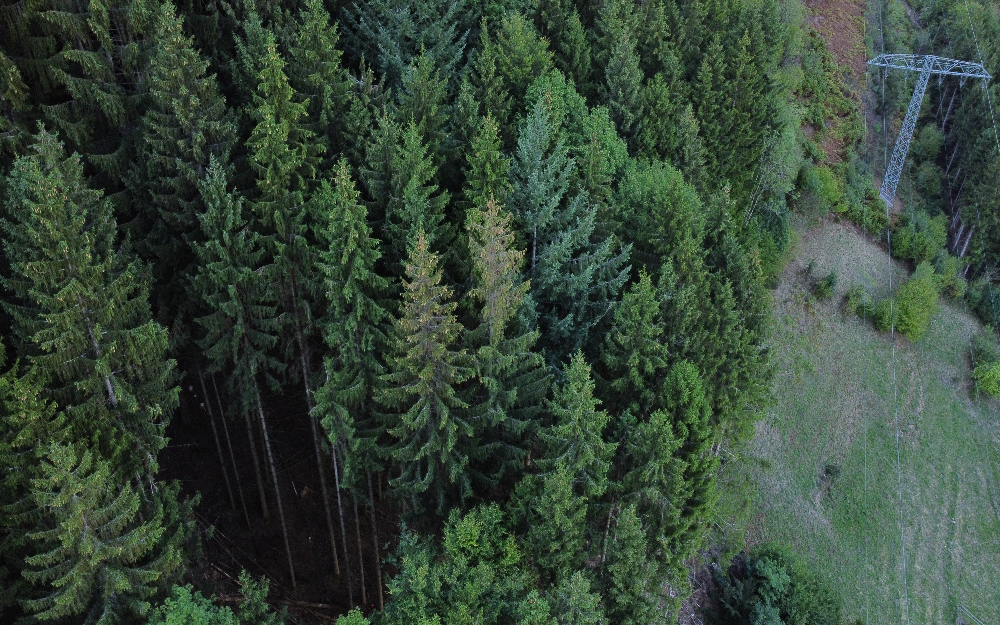

In [10]:
ex_img

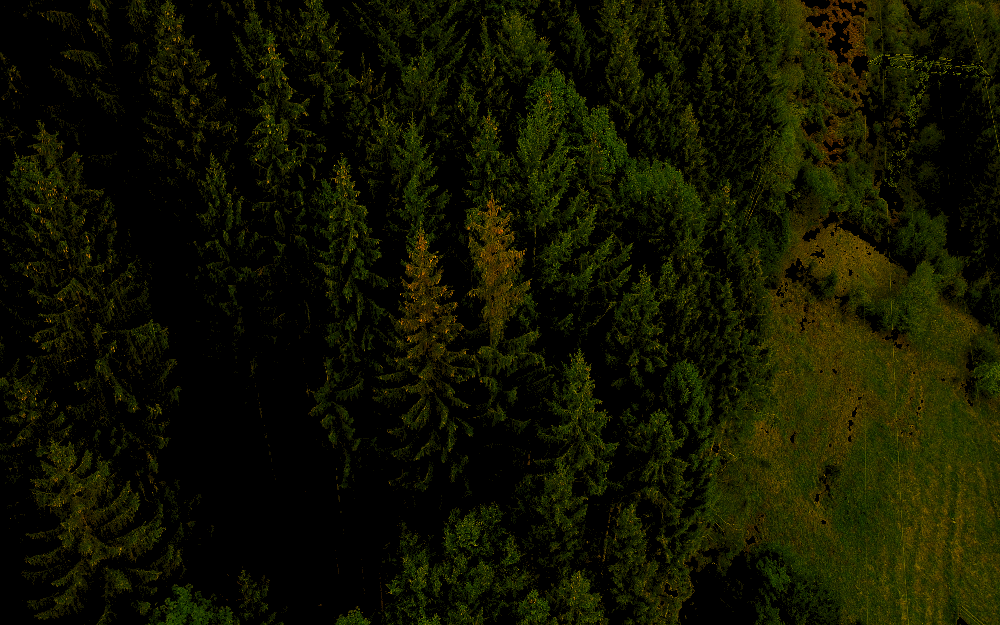

In [11]:
ex_img_cleaned

## 3 - Model Selections

We have decided to implement the following models:

- **Implementation 1:** Naive Classification CNN<br>

<br>

- **Implementation 2:** Localization CNN<br>
Next we'll implement a localization model, in which we will train our model to output a bounding box containing the sick tree feature. To train this, we'll use a data annotation tool to outline the x location, y location, width, and height of the feature's bounding box, and train the model to output those four numbers.
<br>

- **Implementation 3:** Fusion Layer

### **3.1 - Naive Classification CNN**

Our first model, the Naive Classification CNN will attempt to classify images into one of two categories: healthy or sick. <br>
We consider this approach "naive" because it isn't much more than a barebones CNN model with a very standard architecture. Regardless, the model will serve well as a benchmark for CNN performance as well as a stepping stone to more involved models down the line.

#### 3.1.1 - Data Preparation

To prepare our data, we will use tensorflow's ImageDataGenerator to feed images into the CNN's input layer. In this step, we will also augment our data set. Due to our small sample size of 60 images total, our model is very prone to overfitting. Data augmentation attempts to combat this by applying random mutations to the data to generate new observations, such as rotations, shifting the width/height of the image, flipping the images, etc. It will also apply our standard data cleaning function as a preprocessing step to all input passed into the CNN. 

In [12]:
# Load only images that we are interested in for this model
brute_force_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

# Prepare hyperparameters for data
hyperparameters["resize_width"] = 224
hyperparameters["resize_height"] = 224
hyperparameters["resize_size"] = (224, 224)
hyperparameters["batch_size"] = 8
# Prepare hyperparameters for model training
hyperparameters["num_epochs"] = 100
hyperparameters["loss_function"] = 'categorical_crossentropy'

In [13]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_image
)

In [14]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='categorical',
    subset='validation'
)

Found 48 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


#### 3.1.2 - Model Architecture

This model's architecture is very simple.<br>
The input layer takes in images of size (244,244,3) - Images with a resolution of 244x244px, with 3 channels of color information.

There are several hidden layers within the model, primarily Conv2D layers with sizes of 32, 64, 128, and 256 and MaxPooling2D layers between them to extract features from the convolutions.

The output layer is a dense layer with two neurons, using the softmax activation function. The softmax activation function will output two values: the probability that the image contains only healthy trees, and the probability that the image contains at least one sick tree.

For the loss function, we've chosen categorical crossentropy, which is ideal for when attempting to classify images into categories.

In [15]:
# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss=hyperparameters["loss_function"], optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=hyperparameters["num_epochs"], validation_data=validation_generator)

Epoch 1/100
6/6 [==============================] - 24s 4s/step - loss: 3.6544 - accuracy: 0.5208 - val_loss: 0.7716 - val_accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 19s 3s/step - loss: 0.7029 - accuracy: 0.4375 - val_loss: 0.6960 - val_accuracy: 0.0833
Epoch 3/100
6/6 [==============================] - 18s 3s/step - loss: 0.6921 - accuracy: 0.5208 - val_loss: 0.6390 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 19s 3s/step - loss: 0.6537 - accuracy: 0.5417 - val_loss: 0.5390 - val_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 19s 3s/step - loss: 0.5630 - accuracy: 0.8125 - val_loss: 0.6354 - val_accuracy: 0.7500
Epoch 6/100
6/6 [==============================] - 18s 3s/step - loss: 0.5076 - accuracy: 0.7708 - val_loss: 0.7253 - val_accuracy: 0.5833
Epoch 7/100
6/6 [==============================] - 18s 3s/step - loss: 0.4679 - accuracy: 0.7708 - val_loss: 1.4654 - val_accuracy: 0.0000e+00
Epoch 8/100
6/6 [==

#### 3.1.3 - **Results and Discussion:**

In [16]:
# Get the number of validation steps
validation_steps = validation_generator.samples / validation_generator.batch_size

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)

print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

2/2 [==============================] - 4s 1s/step - loss: 1.2565 - accuracy: 0.5833
Validation loss: 1.2565490007400513
Validation accuracy: 0.5833333134651184


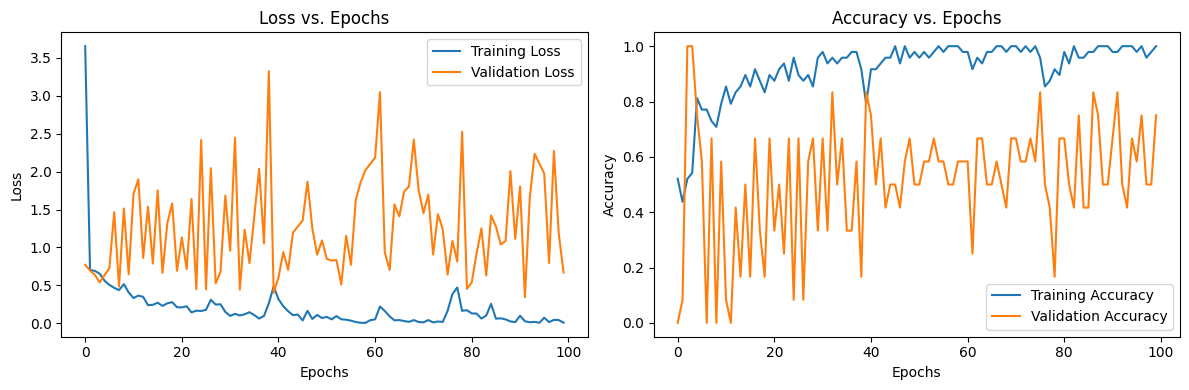

In [17]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot Loss and Accuracy throughout training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

After training, our model reports a validation accuracy of 66%. This is a fairly good result for a very simple model. If we graph the accuracy of our model throughout training, we can see that the accuracy did improve, trending from ~30% accuracy initially to our final accuracy of ~66%. This shows that our model did learn over time to identify sick trees.

The limited data set is a challenge here, and I'm not super confident in achieving a higher result without more observations. It's also worth noting that prior to implementing our data cleaning methods, our accuracy tended to be between 90-100%, but I suspect that this was unrelated to the model actually learning the desired features and had more to do with the very obvious trends in exposure and brightness for healthy/sick images that was discussed in our EDA, rather than the sick features themselves. Though this model has a lower accuracy at 66%, it would likely perform far better than the reportedly higher accuracy model on an expanded data set.

In [18]:
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=clean_image
)

predict_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=hyperparameters["resize_size"],
    batch_size=1,
    class_mode='categorical'
)

results = pd.DataFrame(model.predict(predict_generator))
brute_force_df["predicted_sick_confidence"] = results[1]

def parse_sick_confidence(sick_confidence_percent):
    if sick_confidence_percent >= 0.5:
        return "sick"
    else:
        return "healthy"

brute_force_df["predicted_classification"] = brute_force_df["predicted_sick_confidence"].map(parse_sick_confidence)


Found 60 validated image filenames belonging to 2 classes.
60/60 [==============================] - 18s 281ms/step


In [19]:
predictions_df = brute_force_df[['file_name', 'classification', 'predicted_classification', 'predicted_sick_confidence']]
predictions_df

,file_name,classification,predicted_classification,predicted_sick_confidence
0,data/trees/DJI_0025.JPG,healthy,healthy,1.182280e-03
1,data/trees/DJI_0026.JPG,healthy,sick,8.644220e-01
2,data/trees/DJI_0027.JPG,healthy,sick,9.693736e-01
3,data/trees/DJI_0028.JPG,healthy,healthy,1.583148e-03
4,data/trees/DJI_0029.JPG,healthy,healthy,4.128150e-04
5,data/trees/DJI_0030.JPG,healthy,healthy,6.948394e-12
6,data/trees/DJI_0031.JPG,healthy,sick,9.999257e-01
7,data/trees/DJI_0032.JPG,healthy,sick,8.786227e-01
8,data/trees/DJI_0055.JPG,healthy,healthy,9.031196e-07
9,data/trees/DJI_0063.JPG,healthy,healthy,4.095233e-04


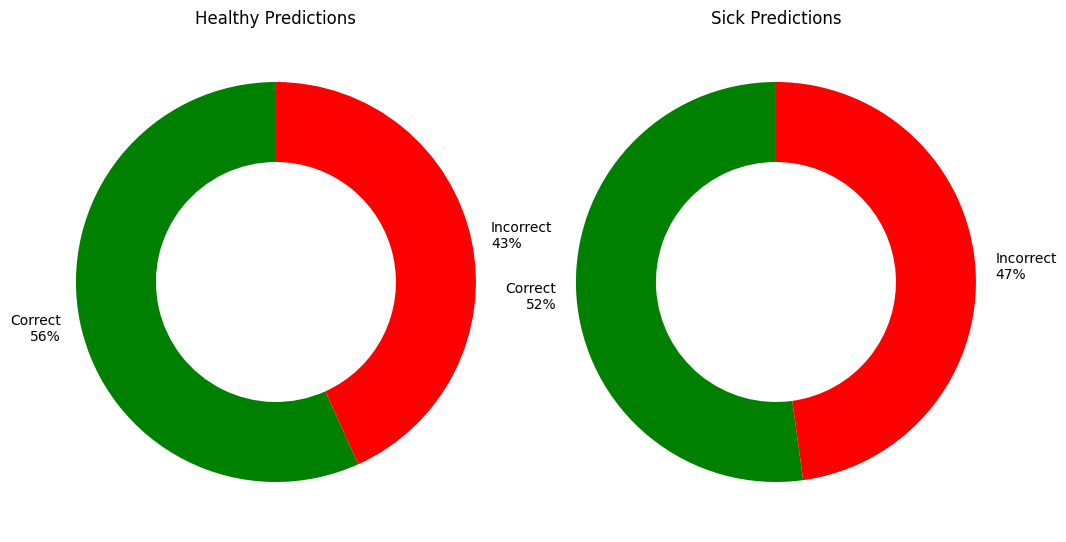

In [280]:
# Data for the pie chart
labels = ["Correct", "Incorrect"]
healthy_mask = predictions_df["classification"] == "healthy"
sick_mask = predictions_df["classification"] == "sick"
healthy_pred_mask = predictions_df["predicted_classification"] == "healthy"
sick_pred_mask = predictions_df["predicted_classification"] == "sick"

healthy_pie = [len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]),len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])]
sick_pie = [len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]),len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])]

colors = ['green', 'red']

# Create the figure and set its size
fig = plt.figure(figsize=(10, 5))

# Create the first pie chart
healthy_labels = [
    "Correct\n"+str(len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) / (len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) + len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])))[2:4]+"%", 
    "Incorrect\n"+str(len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)]) / (len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) + len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])))[2:4]+"%"
    ]
ax1 = fig.add_axes([0, 0, 0.5, 1], aspect=1)
ax1.pie(healthy_pie, labels=healthy_labels, colors=colors, startangle=90, counterclock=True, wedgeprops={'width': 0.4})
ax1.set_title('Healthy Predictions')

# Create the second pie chart
sick_labels = [
    "Correct\n"+str(len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) / (len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) + len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])))[2:4]+"%", 
    "Incorrect\n"+str(len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)]) / (len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) + len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])))[2:4]+"%"
    ]
ax2 = fig.add_axes([0.5, 0, 0.5, 1], aspect=1)
ax2.pie(sick_pie, labels=sick_labels, colors=colors, startangle=90, counterclock=True, wedgeprops={'width': 0.4})
ax2.set_title('Sick Predictions')

plt.show()

If we list out each image, its classification, and the predicted classification (or observe the prediction pie chart), we can see that the accuracy reported is more or less consistent with the predicitons it makes. It also seems to be slightly more effective at correctly classifying sick images than healthy images.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### **3.2 - Naive Localization CNN**

The model above, however, does not totally fulfill the goal of the project. Not only are we interested in identifying the presence or absence of sick trees, we want to locate them within an image. For this we'll be using a localization model, which will predict the coordinates of the bounding box surrounding the feature so that annotations can be drawn.

Once again this model's purpose is mainly exploratory, and the goal is a functioning model that shows improvement

#### 3.2.1 - Data Preparation

The data preparation steps for this model are very similar to the one above, with the key difference being that rather than classification being specified as the response variable, we use the x, y, width, and height data in our prepared metadata file as our output.

In [21]:
# Load only images that we are interested in for this model
localization_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

# Prepare hyperparameters for data
hyperparameters["resize_width"] = 224
hyperparameters["resize_height"] = 224
hyperparameters["resize_size"] = (224, 224)
hyperparameters["batch_size"] = 8
# Prepare hyperparameters for model training
hyperparameters["num_epochs"] = 100
hyperparameters["loss_function"] = 'mean_squared_error'

In [22]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_image
)

In [23]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col=['x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='multi_output',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col=['x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='multi_output',
    subset='validation'
)

Found 48 validated image filenames.
Found 12 validated image filenames.


#### 3.2.2 - Model Architecture

This model is extremely similar to the classification model in nearly all ways, but there are a few key differences. First, our output layer has changed to have four neurons, with a linear activation function. The linear activation function is well-suited to linearly-scaling values without any particular bounds, which is ideal for coordinates like these. Four neurons will output four values, corresponding to our x, y, width, and height bounding box variables. Our loss function for this model is mean squared error, which will train the model to put each coordinate as close to accurate as possible.

In [24]:

# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear')
])

# Compile the model
model.compile(loss=hyperparameters["loss_function"], optimizer='adam')

# Train the model
history = model.fit(train_generator, epochs=hyperparameters["num_epochs"], validation_data=validation_generator)

Epoch 1/100
6/6 [==============================] - 27s 4s/step - loss: 1297174.5000 - val_loss: 160241.4375
Epoch 2/100
6/6 [==============================] - 21s 4s/step - loss: 1059029.7500 - val_loss: 90862.7578
Epoch 3/100
6/6 [==============================] - 20s 3s/step - loss: 1027903.6875 - val_loss: 174049.3750
Epoch 4/100
6/6 [==============================] - 21s 4s/step - loss: 986467.5625 - val_loss: 321240.2188
Epoch 5/100
6/6 [==============================] - 20s 3s/step - loss: 954898.8125 - val_loss: 239521.7969
Epoch 6/100
6/6 [==============================] - 20s 3s/step - loss: 898667.3125 - val_loss: 234565.2344
Epoch 7/100
6/6 [==============================] - 20s 3s/step - loss: 869296.3125 - val_loss: 436407.4062
Epoch 8/100
6/6 [==============================] - 21s 4s/step - loss: 858816.0625 - val_loss: 300413.6250
Epoch 9/100
6/6 [==============================] - 20s 4s/step - loss: 772781.3125 - val_loss: 720125.5000
Epoch 10/100
6/6 [=================

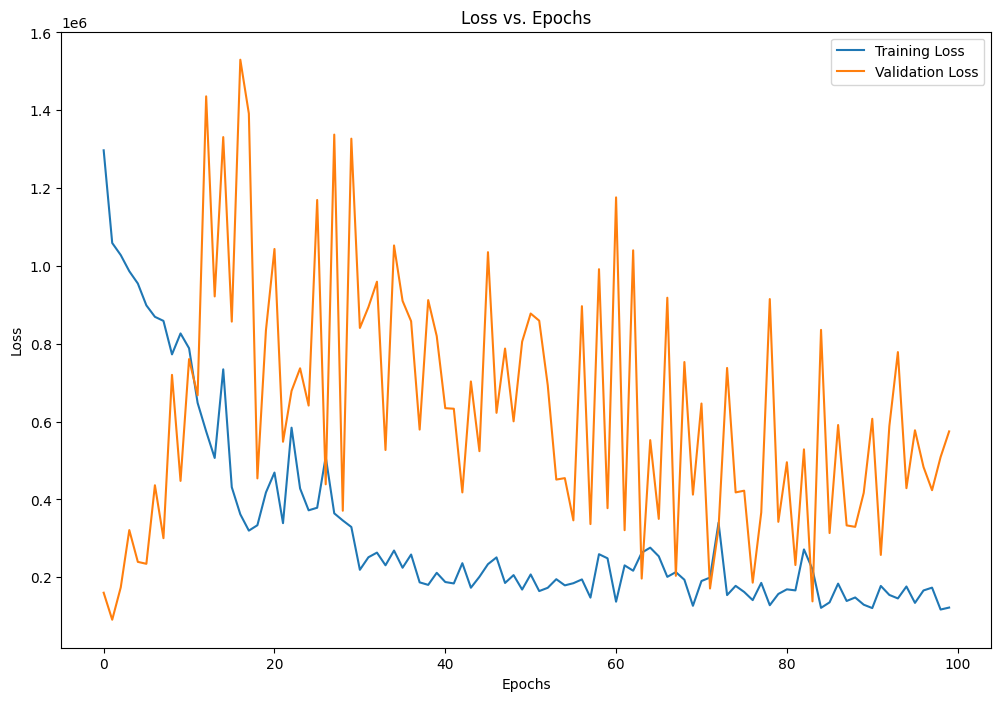

In [103]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot Loss and Accuracy throughout training
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

plt.show()

Observing our model's validation loss throughout training, there was a very minor improvement over time, though the loss value remained very high. It seems safe to say that our model performed consistently poorly despite a similar amount of training time to the first model. I believe this is largely a consequence of our data set's size. With only 24 images containing sick trees, it would be unrealistic to expect the model to learn the complex task of bounding box localization with such a tiny amount of data. Additionally, the Mean Squared Error loss function alone is unsuitable for training an image localization task where the feature may not be present, as . Images of healthy trees, where each value is -1, are likely to confuse the model.

In [25]:
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=clean_image
)

predict_generator = predict_datagen.flow_from_dataframe(
    dataframe=localization_df,
    x_col='file_name',
    y_col=['x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=1,
    class_mode='multi_output',
)

results = pd.DataFrame(model.predict(predict_generator))
localization_df[["pred_x", "pred_y", "pred_w", "pred_h"]] = results



Found 60 validated image filenames.
60/60 [==============================] - 5s 78ms/step


In [26]:
localization_df

,file_name,classification,x,y,width,height,image_data,pred_x,pred_y,pred_w,pred_h
0,data/trees/DJI_0025.JPG,healthy,-1.0,-1.0,-1.0,-1.0,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,-25.526058,-26.284740,-28.526806,-26.386839
1,data/trees/DJI_0026.JPG,healthy,-1.0,-1.0,-1.0,-1.0,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,2.686640,-1.019597,3.881287,1.290859
2,data/trees/DJI_0027.JPG,healthy,-1.0,-1.0,-1.0,-1.0,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,760.359131,765.110107,758.468994,759.302612
3,data/trees/DJI_0028.JPG,healthy,-1.0,-1.0,-1.0,-1.0,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1659.294556,1654.388672,1669.552856,1658.776489
4,data/trees/DJI_0029.JPG,healthy,-1.0,-1.0,-1.0,-1.0,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,-1.679430,-12.457031,-10.407576,-13.437551


In [291]:
# Use some annotation library to draw the predicted bounding boxes on the images being tested

def draw_bounding_box(file_name, x, y, width, height, resize=(-1,-1)):
    img = cv2.imread(file_name)
    if resize != (-1,-1):
        img = cv2.resize(img, resize)
    # annotated_img = img.copy()
    annotated_img = cv2.rectangle(img, (x, y), (x+width, y+height), color=(0,0,255), thickness=5)
    annotated_img = cv2.putText(img, ("x: " + str(x) + ", y: " + str(y) + ", width: " + str(width) + ", height: " + str(height)), (0, annotated_img.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 5, cv2.LINE_AA)
    # annotated_img = cv2.resize(annotated_img, (500,500))
    # annotated_img = image.array_to_img(annotated_img)
    return annotated_img

def save_annotated(save_dir, file_name, x, y, width, height, resize=(-1,-1)):
    save_img = draw_bounding_box(file_name, x, y, width, height)
    if resize != (-1,-1):
        save_img = cv2.resize(save_img, resize)
    cv2.imwrite((save_dir + "/" + file_name.split("/")[-1]), save_img)
    return True

In [292]:
results = localization_df.apply(
    lambda x: save_annotated(
        save_dir="out", 
        file_name=x['file_name'], 
        x=int(x["pred_x"]), 
        y=int(x['pred_y']), 
        width=int(x["pred_w"]), 
        height=int(x["pred_h"])
    ), 
    axis=1
)

Visually observing our model's predictions, it appears that each bounding box coordinate is predicted to be roughly the same value. Notably, every instance where the model correctly attempts to create a non-negative bounding box within an image that contains a sick tree, the four predicted values are in the ballpark of mean of the four true values. I believe that with a substantially larger data set, the model would be able to better learn how to create a true bounding box rather than four values that seem to be attempting to predict the same thing.

In [105]:
# draw_bounding_box(localization_df.iloc[40]["file_name"], int(localization_df.iloc[40]["pred_x"]), int(localization_df.iloc[40]["pred_y"]), int(localization_df.iloc[40]["pred_w"]), int(localization_df.iloc[40]["pred_h"]))

### 3.3 - Classification-Localization Fusion CNN (ft. Transfer Learning)

Without the ability to collect more observations, the issue of our small data set is difficult to combat. However, there are some ways we can deal with the issues in previous models.

One possible way to boost model performance without more images is to repurpose an existing trained model, retraining it to fit our desired use case. By importing a model, cutting off the output layer and putting our own on it before training allows it to keep associations it's already made regarding things like shape and color information, optimal filter selection, etc., but can relearn which features are important in our particular image processing task.

Another source of error in the above model we can address is the loss function. The MSE loss function is not entirely suitable for a task like this, where a coordinate value of -1 is categorical, but any other value is not.

We will need to retrain an existing model for the task of both classifying and localizing the bounding box, and create a custom loss function such that the model ignores localization loss for images of healthy trees.

#### 3.3.1 - Data Preparation

Unlike the above models, this model will scale the x, y, width, and height annotations into a 224x224 coordinate system, as we're using a model that has been pretrained to use images of that size. This may help the model use its existing neurons to identify the location of features in the image set for our bounding box placement.

We will also be rewriting the classification field of our data to be a binary value: 0 if healthy, 1 if sick. This will help later on, as we are using a different loss function.

For our ImageDataGenerator, we will be including five values: classification, x, y, width, and height, as this model is supposed to predict the classification as well as the bounding box coordinates. We will also be designating our class_mode as 'raw' so that we can more easily customize our loss function.

In [252]:
# Load only images that we are interested in for this model
class_local_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]
class_local_df['classification'] = class_local_df['classification'].apply(lambda x: 1 if x == 'sick' else 0)

class_local_df['x'] = class_local_df['x'].apply(lambda x: -1 if x == -1 else int(x * (224/4000)))
class_local_df['y'] = class_local_df['y'].apply(lambda x: -1 if x == -1 else int(x * (224/2500)))
class_local_df['width'] = class_local_df['width'].apply(lambda x: -1 if x == -1 else int(x * (224/4000)))
class_local_df['height'] = class_local_df['height'].apply(lambda x: -1 if x == -1 else int(x * (224/2500)))

# Prepare hyperparameters for data
hyperparameters["resize_width"] = 224
hyperparameters["resize_height"] = 224
hyperparameters["resize_size"] = (224, 224)
hyperparameters["batch_size"] = 4
# Prepare hyperparameters for model training
hyperparameters["num_epochs"] = 200
hyperparameters["classification_weight"] = 1.0

In [253]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_image
)

In [254]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=class_local_df,
    x_col='file_name',
    y_col=['classification','x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='raw',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=class_local_df,
    x_col='file_name',
    y_col=['classification','x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=hyperparameters["batch_size"],
    class_mode='raw',
    subset='validation'
)

Found 48 validated image filenames.
Found 12 validated image filenames.


#### 3.3.2 - Model Architecture

Our model's architecture will differ from the previous models fairly drastically.

First of all, we will be writing our own loss function for this model. This loss function considers both the classification and localization loss for our model. We've also introduced a new hyperparameter, classification_weight, to use to refine our model's hyperparameters later.

In [257]:
# Define custom loss function
def combined_loss(y_true, y_pred):
    y_true_classification = y_true[:, 0]
    y_true_localization = y_true[:, 1:]
    
    y_pred_classification = y_pred[:, 0]
    y_pred_localization = y_pred[:, 1:]

    # mask = tf.cast(tf.math.equal(y_true_classification, 1), tf.float32)
    # mask = tf.expand_dims(mask, axis=-1)

    # y_true_localization *= mask
    # y_pred_localization *= mask
    
    classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true_classification, y_pred_classification)
    localization_loss = tf.keras.losses.MeanSquaredError()(y_true_localization, y_pred_localization)
    
    return (hyperparameters["classification_weight"] * classification_loss) + localization_loss

For this model, we will be importing an existing model to retrain. We've chosen MobileNetV2, as it's used very often for image classification tasks such as this, and it'll likely fit quite well to its new task as a classifier-localizer. There are plenty of other options, so if it doesn't work, we can always try using a different model.

We'll import the model without the output layers, as we'll want to use our own. We'll use a single Dense layer with 5 neurons, one for each output. We won't use an activation function for this layer, as it varies depending on neuron. We'll apply activation functions to slices of our output, sigmoid activation for the classification output and default for the coordinates. We'll combine our outputs back into a single tensor for the sake of validation.

For this model, we are also going to use a smaller batch size of 4 with a higher number of epochs to attempt to offset the issue of our small dataset. However, to prevent overfitting, we'll also be implementing an early stopping technique to stop training once validation loss stops improving.

In [258]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation=None, name='output')(x)
classification_output = tf.sigmoid(output[:, 0])
localization_output = output[:, 1:]
combined_output = tf.concat([classification_output[:, tf.newaxis], localization_output], axis=1)

# Create Model
model = Model(inputs=base_model.input, outputs=combined_output)

# Compile the model
model.compile(loss=combined_loss, optimizer='adam')

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(train_generator, epochs=hyperparameters["num_epochs"], validation_data=validation_generator,
    callbacks=[early_stopping])


Epoch 1/100
6/6 [==============================] - 23s 2s/step - loss: 1975.6949 - val_loss: 8.9090
Epoch 2/100
6/6 [==============================] - 9s 1s/step - loss: 1459.0048 - val_loss: 246.1116
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 1244.1544 - val_loss: 171.4872
Epoch 4/100
6/6 [==============================] - 9s 1s/step - loss: 889.3692 - val_loss: 1825.4498
Epoch 5/100
6/6 [==============================] - 8s 1s/step - loss: 694.2824 - val_loss: 7079.8750
Epoch 6/100
6/6 [==============================] - 9s 1s/step - loss: 581.6110 - val_loss: 5412.7241
Epoch 7/100
6/6 [==============================] - 9s 1s/step - loss: 573.9313 - val_loss: 2006.5846
Epoch 8/100
6/6 [==============================] - 9s 1s/step - loss: 426.8047 - val_loss: 6472.3530
Epoch 9/100
6/6 [==============================] - 9s 1s/step - loss: 538.6766 - val_loss: 14642.6045
Epoch 10/100
6/6 [==============================] - 8s 1s/step - loss: 294.3922 - val_loss:

#### 3.3.3 - Results and Discussion

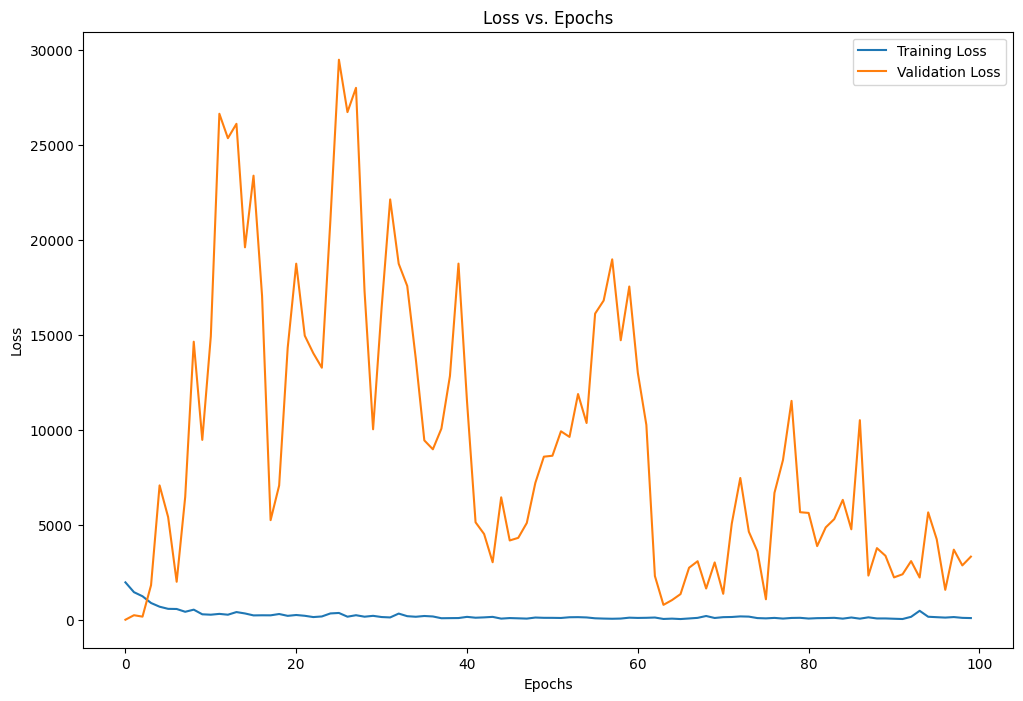

In [260]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot Loss and Accuracy throughout training
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

plt.show()

In [261]:
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=clean_image
)

predict_generator = predict_datagen.flow_from_dataframe(
    dataframe=class_local_df,
    x_col='file_name',
    y_col=['classification','x','y','width','height'],
    target_size=hyperparameters["resize_size"],
    batch_size=1,
    class_mode='raw',
)

results = pd.DataFrame(model.predict(predict_generator))
class_local_df[["pred_class", "pred_x", "pred_y", "pred_w", "pred_h"]] = results



Found 60 validated image filenames.
60/60 [==============================] - 7s 100ms/step


In [262]:
class_local_df["pred_class"] = class_local_df["pred_class"].apply(lambda x: 0 if x < 0.5 else 1)

In [263]:
class_local_df

,file_name,classification,x,y,width,height,image_data,pred_class,pred_x,pred_y,pred_w,pred_h
0,data/trees/DJI_0025.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,0,53.608612,70.138062,11.244476,19.931807
1,data/trees/DJI_0026.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1,113.880409,98.486313,24.945019,43.719673
2,data/trees/DJI_0027.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,0,90.422577,98.737350,10.704990,19.676138
3,data/trees/DJI_0028.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1,73.671021,75.014793,11.469350,21.425074
4,data/trees/DJI_0029.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,0,-36.642578,12.286233,-14.489244,-26.676939
5,data/trees/DJI_0030.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1,122.515549,80.274376,21.905470,42.835617
6,data/trees/DJI_0031.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,0,46.653984,61.615429,0.707815,1.321187
7,data/trees/DJI_0032.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1,132.743851,108.443192,28.801804,53.953373
8,data/trees/DJI_0055.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,1,119.350266,91.183830,28.832048,52.257797
9,data/trees/DJI_0063.JPG,0,-1,-1,-1,-1,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,0,84.565491,92.952988,11.935230,21.670321


In [293]:
results = class_local_df.apply(
    lambda x: save_annotated(
        save_dir="out_class_local", 
        file_name=x['file_name'], 
        x=int(x["pred_x"] * (4000 / 224)), 
        y=int(x['pred_y'] * (2500 / 224)), 
        width=int(x["pred_w"] * (4000 / 224)), 
        height=int(x["pred_h"] * (2500 / 224)),
        resize=(1000,625)
    ), 
    axis=1
)

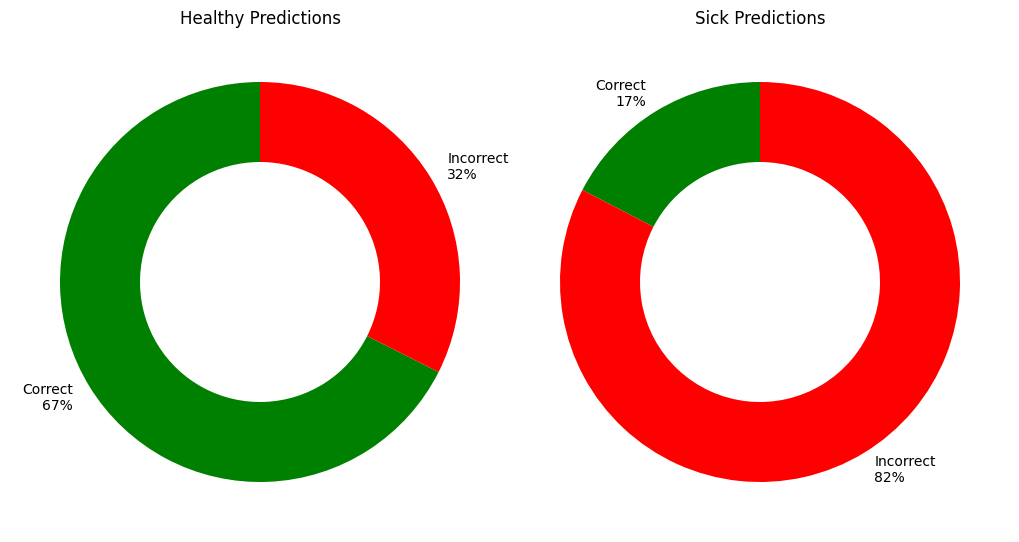

In [281]:
# Data for the pie chart

healthy_mask = class_local_df["classification"] == 0
sick_mask = class_local_df["classification"] == 1
healthy_pred_mask = class_local_df["pred_class"] == 0
sick_pred_mask = class_local_df["pred_class"] == 1

healthy_pie = [len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]),len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])]
sick_pie = [len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]),len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])]

colors = ['green', 'red']

# Create the figure and set its size
fig = plt.figure(figsize=(10, 5))

# Create the first pie chart
healthy_labels = [
    "Correct\n"+str(len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) / (len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) + len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])))[2:4]+"%", 
    "Incorrect\n"+str(len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)]) / (len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)]) + len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])))[2:4]+"%"
    ]
ax1 = fig.add_axes([0, 0, 0.5, 1], aspect=1)
ax1.pie(healthy_pie, labels=healthy_labels, colors=colors, startangle=90, counterclock=True, wedgeprops={'width': 0.4})
ax1.set_title('Healthy Predictions')

# Create the second pie chart
sick_labels = [
    "Correct\n"+str(len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) / (len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) + len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])))[2:4]+"%", 
    "Incorrect\n"+str(len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)]) / (len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)]) + len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])))[2:4]+"%"
    ]
ax2 = fig.add_axes([0.5, 0, 0.5, 1], aspect=1)
ax2.pie(sick_pie, labels=sick_labels, colors=colors, startangle=90, counterclock=True, wedgeprops={'width': 0.4})
ax2.set_title('Sick Predictions')

plt.show()

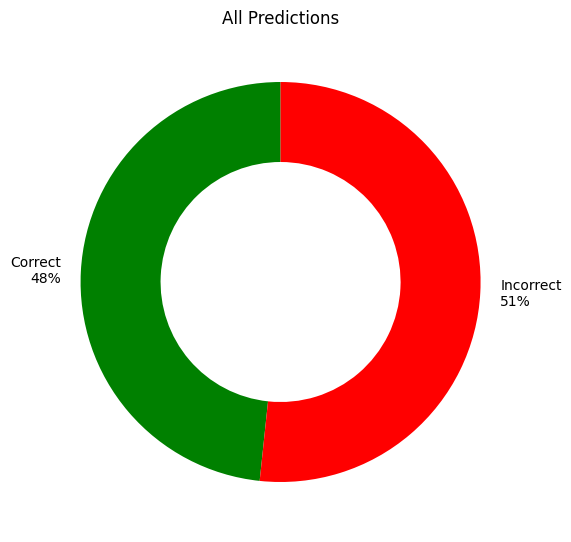

In [285]:
# Data for the pie chart

healthy_mask = class_local_df["classification"] == 0
sick_mask = class_local_df["classification"] == 1
healthy_pred_mask = class_local_df["pred_class"] == 0
sick_pred_mask = class_local_df["pred_class"] == 1

num_correct = len(predictions_df[np.logical_and(healthy_mask, healthy_pred_mask)])+len(predictions_df[np.logical_and(sick_mask, sick_pred_mask)])
num_incorrect = len(predictions_df[np.logical_and(healthy_mask, sick_pred_mask)])+len(predictions_df[np.logical_and(sick_mask, healthy_pred_mask)])

all_pie = [num_correct, num_incorrect]
colors = ['green', 'red']

# Create the figure and set its size
fig = plt.figure(figsize=(10, 5))

# Create the pie chart
labels = [
    "Correct\n"+str(num_correct / (num_correct+num_incorrect))[2:4]+"%",
    "Incorrect\n"+str(num_incorrect / (num_correct+num_incorrect))[2:4]+"%"
]
ax1 = fig.add_axes([0, 0, 0.5, 1], aspect=1)
ax1.pie(all_pie, labels=labels, colors=colors, startangle=90, counterclock=True, wedgeprops={'width': 0.4})
ax1.set_title('All Predictions')

plt.show()